### 1\. Analysis: Frame the Problem and Look at the Big Picture

#### 1.1. Identifying the Problem/Task

The chosen problem revolves around creating a model that can play the card game Blackjack effectively. The task is intriguing due to the combination of strategy, probability, and decision-making involved, which makes it an excellent candidate for exploring machine learning techniques. Blackjack offers a structured environment where outcomes depend not only on chance but also on optimal decisions, aligning well with the capabilities of neural networks to learn complex patterns and strategies.

#### 1.2. Defining the Objective in Business Terms

The primary objective is to develop a system that learns to play Blackjack proficiently and maximizes cumulative rewards over a series of games. In business terms, this can be equated to building an AI capable of making decisions to maximize earnings in a casino environment. Such a model could potentially be used in simulation tools, training programs for players, or to demonstrate the effectiveness of various machine learning techniques in solving decision-based problems.

#### 1.3. Framing the Problem

This problem is best framed as a **supervised learning** task. The model learns to make decisions (hit, stand, double down, or split) by training on labeled datasets where each input (current game state) is paired with the optimal action derived from established Blackjack strategies or simulations. By treating the task as a supervised learning problem, the focus is on mapping game states to decisions effectively.


#### 1.4. Measuring Performance

**Accuracy**: The percentage of decisions made by the model that match the optimal strategy in the training data. This metric evaluates how well the model has learned from the labeled examples and reflects its ability to replicate the decisions of an ideal player. High accuracy indicates the model is effectively capturing the relationships between game states and optimal actions. 

</br>
<p align="center">
  <img src="images/bjTbale.png" width="900"/>
</p>



### 1.1 Imports
#### The necessary libraries for data manipulation, model building, and evaluation were imported for the analysis.


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import regularizers
import ast
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, LSTM,Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

### 1.2 Data
#### The perfect strategy blackjack hand generator
 The dataset used for this analysis is sourced from a Blackjack simulator available on GitHub (https://github.com/dennis-ho/blackjack-simulator). A minor bug was addressed in the simulator, which previously allowed the dealer to bust even after the player had already busted. This fix ensures the game logic correctly handles such scenarios. The advantage of using this simulator is that it provides a flexible and customizable dataset, allowing us to manipulate and modify the data in various ways to better suit our model’s needs and experimentation, ultimately leading to more precise insights and predictions.



In [166]:
data = pd.read_csv('blackjack_simulator.csv')
data.head()

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 10]","[10, 4, 2, 7]",23,"[[10, 10]]",[20],[['S']],-1,0,1.0
1,0,410,2,"[10, 10]","[2, 10, 7]",19,"[[10, 10]]",[20],[['S']],-2,0,1.0
2,0,405,10,"[2, 10]","[10, 3, 2, 11, 5]",21,"[[2, 10, 6]]",[18],"[['H', 'S']]",-4,0,-1.0
3,0,397,11,"[2, 11]","[11, 10]",BJ,"[[2, 11]]",[13],[['N']],-2,0,-1.0
4,0,393,2,"[3, 9]","[2, 4, 2, 10]",18,"[[3, 9, 8]]",[20],"[['H', 'S']]",-4,0,1.0


### 3. Exploring the data

During the data exploration phase, we performed several key analyses:

1. **Feature Correlation Heatmap**: We visualized correlations between features using a heatmap. This allowed us to observe relationships between variables, particularly noting a strong correlation between the `true_count` and `running_count`. However, since these features were unnecessary for our model, we decided to remove them.

2. **Outlier Detection**: We assessed the data for outliers. Given that we generated our own data, no significant outliers were present. This was expected, as we controlled the data generation process to avoid any irregularities.

3. **Percentage of Missing Values**: We also checked for missing data, and as anticipated, there were no missing values, thanks to the synthetic nature of our dataset.

After this analysis, we decided to retain only the most relevant features for our model:
- `dealer_up`: The dealer's visible card, which the player can see before making any actions.
- `initial_hand`: The player's hand before any actions (e.g., hit, stand).
- `player_final`: The player's hand after all actions are completed.
- `actions_taken`: The sequence of actions the player took during the game.

These features were deemed most important for modeling the decision-making process in Blackjack.


Number of outliers per column:
shoe_id               0
cards_remaining       0
dealer_up             0
run_count          1345
true_count         5322
win                  32
dtype: int64

Percentage of missing values per column:
shoe_id               0.00%
cards_remaining       0.00%
dealer_up             0.00%
initial_hand          0.00%
dealer_final          0.00%
dealer_final_value    0.00%
player_final          0.00%
player_final_value    0.00%
actions_taken         0.00%
run_count             0.00%
true_count            0.00%
win                   0.00%
dtype: object


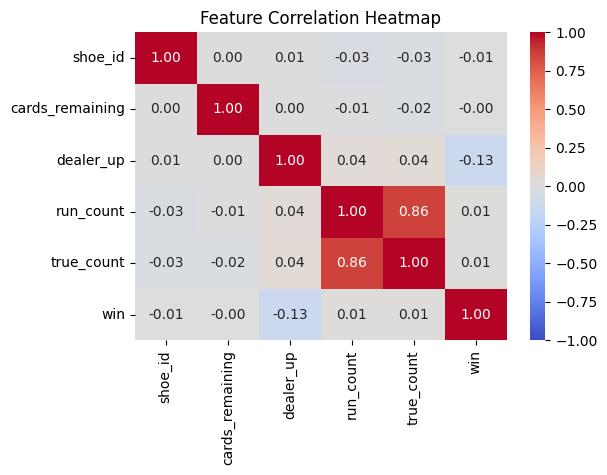

In [167]:
numeric_data = data.select_dtypes(include=['number'])

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

outliers = (numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))

outlier_counts = outliers.sum()
print("Number of outliers per column:")
print(outlier_counts)

missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage.apply(lambda x: f"{x:.2f}%")
print("\nPercentage of missing values per column:")
print(missing_percentage)

#correlation between features
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

### 4\. Preparing the Data
#### 4.1 Removing the unnecessary 
We began by removing unnecessary columns to focus on the most relevant features. The retained features were:

1.  **dealer_up**: The dealer's visible card.
2.  **initial_hand**: The player's hand before any actions.
3.  **player_final**: The player's final hand after actions.
4.  **actions_taken**: The sequence of actions taken by the player.

In [168]:
#data we are interested on
data_filtered = data[["dealer_up", "initial_hand", "player_final", "actions_taken"]]

#this is for the string representations of the arrays in the cvs file to be actually converted to arrays
data_filtered.loc[:, 'initial_hand'] = data_filtered['initial_hand'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_filtered.loc[:, 'player_final'] = data_filtered['player_final'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_filtered.loc[:, 'actions_taken'] = data_filtered['actions_taken'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#make sure it still works :)
print(data_filtered.head())

   dealer_up initial_hand  player_final actions_taken
0         10     [10, 10]    [[10, 10]]         [[S]]
1          2     [10, 10]    [[10, 10]]         [[S]]
2         10      [2, 10]  [[2, 10, 6]]      [[H, S]]
3         11      [2, 11]     [[2, 11]]         [[N]]
4          2       [3, 9]   [[3, 9, 8]]      [[H, S]]


#### 4.2 Row enhancements
In this step, we’re breaking down each game round into individual actions so the model can learn what to do at each step. Instead of having one row for the entire game with multiple actions, we create separate rows for each action.

This: 
| dealer_up | initial_hand | player_final | actions_taken |
|:--------:|:--------:|:--------:|:--------:|
|  4   |  [5, 3]   |  [[5, 3, 10]]   |  [[H, S]]   |

Turns into this:
| dealer_up | current_hand | action | current_hand_value |
|:--------:|:--------:|:--------:|:--------:|
|  4   |  [5, 3]   |  H   |  8   |
|  4   |  [5, 3, 10]   |  S   |  18   |

In the first row, the player starts with [5, 3] and takes the action "H" (Hit). The hand value is 8 (5 + 3). In the second row, the hand becomes [5, 3, 10], and the player stands ("S") with a value of 18.

This process helps the model predict what action to take at each step, based on the current hand and dealer’s upcard.

In [169]:

expanded_rows = []

# Function to calculate the hand value with Ace as 11 if possible, otherwise as 1
def calculate_hand_value(hand, hit_or_double=False):
    total = sum(card if card != 11 else 1 for card in hand) 
    aces = hand.count(11)
    while aces > 0 and total + 10 <= 21:
        total += 10  
        aces -= 1
    
    # If "Hit" or "Double", check if total goes above 21 and downgrade Ace to 1
    if hit_or_double and total > 21:
        total = sum(card if card != 11 else 1 for card in hand)
        aces = hand.count(11) 
        while aces > 0 and total + 10 <= 21:
            total += 10  
            aces -= 1

    return total

# Process each row in the DataFrame
for index, row in data_filtered.iterrows():
    hands = [row['initial_hand']]  
    action_groups = row['actions_taken']  
    hand_idx = 0 

    # Process each hand and its corresponding actions
    while hand_idx < len(action_groups) and hands:
        current_hand = hands.pop(0)  
        actions = action_groups[hand_idx] 

        # Process actions for the current hand
        for action in actions:
            hit_or_double = action in ['H', 'D']
            hand_value = calculate_hand_value(current_hand, hit_or_double)

            # Ensure hand value doesn't exceed 21 after hit or double
            if hand_value > 21:
                hand_value = sum(card if card != 11 else 1 for card in current_hand) 

            # Create a row for the current action
            new_row = {
                'dealer_up': row['dealer_up'],
                'current_hand': current_hand.copy(), 
                'action': action,
                'current_hand_value': hand_value,  
            }
            expanded_rows.append(new_row)

            # Handle split action (P)
            if action == 'P' and len(current_hand) == 2:
                break  
            elif action in ['H', 'D']: 
                next_card = row['player_final'][hand_idx][len(current_hand)]
                current_hand.append(next_card)

        # After handling actions for the current hand, move to the next hand
        if len(hands) > 0:
            hand_idx += 1 

expanded_data = pd.DataFrame(expanded_rows)

expanded_data

,dealer_up,current_hand,action,current_hand_value
0,10,"[10, 10]",S,20
1,2,"[10, 10]",S,20
2,10,"[2, 10]",H,12
3,10,"[2, 10, 6]",S,18
4,11,"[2, 11]",N,13
...,...,...,...,...
139264,8,"[2, 3, 8, 5]",S,18
139265,4,"[10, 3]",S,13
139266,10,"[5, 10]",R,15
139267,7,"[10, 3]",H,13


#### 4.3 Model confusion
Initially, when we trained the model, it was confusing the actions of double down, hit, and split with stand. To address this, we performed data enhancements, taking advantage of the flexibility of our dataset. These enhancements provided the model with more specific features and context, allowing it to better understand the game's dynamics and make more accurate predictions for each action.
#### The confusion matrix:
</br>

<p align="center">
  <img src="images/confusionMatrix.png" width="900"/>
</p>


#### What we added:
 
-   **Dealer Lose Probability**: Helps predict when the dealer is likely to bust.

-   **Player Bust Probability**: Indicates the risk of the player busting.

-   **Hand Type**: Categorizes hands as 'Blackjack', 'Soft', 'Hard', or 'Pair' for better decision-making.

-   **Dealer Ace Indicator**: Flags if the dealer has an Ace, affecting their strategy.

-   **More Than Two Cards**: Shows if the player's hand has more than two cards, reflecting actions taken.

-   **Double Down Decision**: Labels when to double down, guiding the model's decisions.

In [170]:
#calculate the bust probability for the dealers upcard
# odds based on https://www.cachecreek.com/blackjack-odds
def dealer_lose_probability(dealer_upcard, player_hand_total):
    base_bust_probabilities = {
        2: 0.35,  
        3: 0.37, 
        4: 0.40, 
        5: 0.42,  
        6: 0.42,  
        7: 0.26, 
        8: 0.24,  
        9: 0.23,  
        10: 0.17,
        11: 0.14 
    }
    
    base_probability = base_bust_probabilities.get(dealer_upcard, 0)
    
    if player_hand_total >= 18:
        if dealer_upcard in [4, 5, 6]:
            adjustment_factor = 0.15 
        elif dealer_upcard in [7, 8, 9]:
            adjustment_factor = 0.10  
        elif dealer_upcard in [10, 11]:
            adjustment_factor = 0.05  
        else:
            adjustment_factor = 0.10  
    elif player_hand_total >= 14:
        if dealer_upcard in [4, 5, 6]:
            adjustment_factor = 0.08  
        elif dealer_upcard in [7, 8, 9]:
            adjustment_factor = 0.05 
        elif dealer_upcard in [10, 11]:
            adjustment_factor = 0.03  
        else:
            adjustment_factor = 0.05  
    elif player_hand_total >= 12:
        if dealer_upcard in [4, 5, 6]:
            adjustment_factor = 0.05  
        elif dealer_upcard in [7, 8, 9]:
            adjustment_factor = 0.03  
        elif dealer_upcard in [10, 11]:
            adjustment_factor = 0.01  
        else:
            adjustment_factor = 0.03 
    else:
        adjustment_factor = 0.0
    adjusted_probability = base_probability + adjustment_factor
    adjusted_probability = min(max(adjusted_probability, 0), 1)

    return adjusted_probability

#calculate the bust probability for the player
# odds based on https://www.cachecreek.com/blackjack-odds
def player_bust_probability(player_hand_total):
    bust_probabilities = {
        21: 1.00, 
        20: 0.92,  
        19: 0.85, 
        18: 0.77, 
        17: 0.69, 
        16: 0.62,  
        15: 0.58, 
        14: 0.56,  
        13: 0.39, 
        12: 0.31,
    }
    
    if(player_hand_total<12):
        return 0
    else:
        return bust_probabilities.get(player_hand_total)    

expanded_data['dealer_lose_probability'] = expanded_data.apply(
    lambda row: dealer_lose_probability(int(row['dealer_up']),int(row['current_hand_value'])), axis=1
)
expanded_data['player_bust_probability'] = expanded_data.apply(
    lambda row: player_bust_probability(int(row['current_hand_value'])), axis=1
)
expanded_data.head()

def hand_type(hand):
    if 11 in hand and sum(hand) == 21:  
        return 'BlackJack'
    elif 11 in hand and sum(hand) < 21:
        return 'Soft'
    elif hand[0] == hand[1]:
        return 'Pair'
    else:
        return 'Hard'

expanded_data['hand_type'] = expanded_data['current_hand'].apply(hand_type)

def dealer_ace(card):
    if 11 == card:
        return 1
    else:
        return 0

expanded_data['dealer_ace'] = expanded_data['dealer_up'].apply(dealer_ace)

def count_cards(hand):
    return 1 if len(hand) > 2 else 0

expanded_data['more_than_two_cards'] = expanded_data['current_hand'].apply(count_cards)

def should_double_down(row):

    if row['current_hand_value'] == 11:  
        return 1 
    elif row['current_hand_value'] == 10:  
        return 1 if row['dealer_up'] in range(2, 10) else 0  
    elif row['current_hand_value'] == 9: 
        return 1 if row['dealer_up'] in range(3, 7) else 0  
    
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 18:  
        return 1 if row['dealer_up'] == 6 else 0  
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 17:  
        return 1 if row['dealer_up'] in range(3, 7) else 0  
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 16: 
        return 1 if row['dealer_up'] in range(4, 7) else 0  
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 15: 
        return 1 if row['dealer_up'] in range(4, 7) else 0  
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 14: 
        return 1 if row['dealer_up'] in range(5, 7) else 0 
    elif row['hand_type'] == 'Soft' and row['current_hand_value'] == 13: 
        return 1 if row['dealer_up'] in range(5, 7) else 0 

    elif row['hand_type'] == 'Pair' and row['current_hand_value'] == 5: 
        return 1 if row['dealer_up'] in range(2, 10) else 0 
    elif row['hand_type'] == 'Pair' and row['current_hand_value'] == 9: 
        return 1 if row['dealer_up'] in range(2, 10) and row['dealer_up'] != 7 else 0  

    return 0  

expanded_data['should_double_down'] = expanded_data.apply(should_double_down, axis=1)

# no longer needed
expanded_data.drop(columns=['current_hand'], inplace=True)

expanded_data

,dealer_up,action,current_hand_value,dealer_lose_probability,player_bust_probability,hand_type,dealer_ace,more_than_two_cards,should_double_down
0,10,S,20,0.22,0.92,Pair,0,0,0
1,2,S,20,0.45,0.92,Pair,0,0,0
2,10,H,12,0.18,0.31,Hard,0,0,0
3,10,S,18,0.22,0.77,Hard,0,1,0
4,11,N,13,0.15,0.39,Soft,1,0,0
...,...,...,...,...,...,...,...,...,...
139264,8,S,18,0.34,0.77,Hard,0,1,0
139265,4,S,13,0.45,0.39,Hard,0,0,0
139266,10,R,15,0.20,0.58,Hard,0,0,0
139267,7,H,13,0.29,0.39,Hard,0,0,0


### 4.4 One-hot encode 'actions' and Ordinal encode 'hand_type'
We used **Ordinal encoding** for the 'hand_type' variable to convert string values (e.g., 'Soft', 'Hard', 'Pair') into numeric values, making it easier for the model to process.

For the **actions** variable, we applied **One-hot encoding**. This converts the categorical actions (like 'Hit', 'Stand', 'Double Down') into binary vectors, allowing the model to predict each action independently. This step helps the model better understand and predict specific actions during training.

We also applied **scaling** to the numeric columns (`'dealer_up'`, `'current_hand_value'`, `'dealer_lose_probability'`, `'player_bust_probability'`, and `'should_double_down'`) using **MinMaxScaler**. This normalization ensures that all numeric features are on the same scale, improving the model's performance and convergence.

Additionally, we removed rows where all action columns (such as 'DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER') were set to 0. This step is necessary because a perfect Blackjack strategy does not include the 'INSURANCE' options, so we eliminated them to focus on the relevant actions.

In [171]:
#One-hot encode 'actions'
action_mapping = {
    'H': 'HIT',
    'S': 'STAND',
    'D': 'DOUBLE_DOWN',
    'P': 'SPLIT',
    'R': 'SURRENDER',
}

expanded_data['action'] = expanded_data['action'].map(action_mapping)
one_hot_encoded = pd.get_dummies(expanded_data['action'], prefix='', prefix_sep='')
one_hot_encoded = one_hot_encoded.astype(int)
expanded_data = pd.concat([expanded_data, one_hot_encoded], axis=1)
expanded_data.drop(columns=['action'], inplace=True)

# Ordinal encode 'hand_type'
hand_type_order = ['Hard', 'Soft', 'Pair', 'BlackJack']
ordinal_encoder = OrdinalEncoder(categories=[hand_type_order])
expanded_data['hand_type'] = ordinal_encoder.fit_transform(expanded_data[['hand_type']]).astype(int)


numeric_columns = ['dealer_up', 'current_hand_value', 'dealer_lose_probability', 'player_bust_probability','should_double_down']
scaler = MinMaxScaler()

#scaling
expanded_data[numeric_columns] = scaler.fit_transform(expanded_data[numeric_columns])

columns_to_check = ['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']
# Remove rows where all specified columns are equal to 0
expanded_data = expanded_data.loc[~(expanded_data[columns_to_check] == 0).all(axis=1)]

# Display the resulting DataFrame
expanded_data

,dealer_up,current_hand_value,dealer_lose_probability,player_bust_probability,hand_type,dealer_ace,more_than_two_cards,should_double_down,DOUBLE_DOWN,HIT,SPLIT,STAND,SURRENDER
0,0.888889,0.941176,0.186047,0.92,2,0,0,0.0,0,0,0,1,0
1,0.000000,0.941176,0.720930,0.92,2,0,0,0.0,0,0,0,1,0
2,0.888889,0.470588,0.093023,0.31,0,0,0,0.0,0,1,0,0,0
3,0.888889,0.823529,0.186047,0.77,0,0,1,0.0,0,0,0,1,0
5,0.000000,0.470588,0.558140,0.31,0,0,0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139264,0.666667,0.823529,0.465116,0.77,0,0,1,0.0,0,0,0,1,0
139265,0.222222,0.529412,0.720930,0.39,0,0,0,0.0,0,0,0,1,0
139266,0.888889,0.647059,0.139535,0.58,0,0,0,0.0,0,0,0,0,1
139267,0.555556,0.529412,0.348837,0.39,0,0,0,0.0,0,1,0,0,0


### 5. The Models
#### 5.1  XGBoost
To train our XGBoost model, we first separated the features and target variables. The features, `X`, consist of all the columns except for the action columns ('DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER'), which are used as our target variable `y`. For the target, we converted the action labels into numeric values by using `idxmax`, which selects the action with the highest value for each row, and then encoded it into categorical codes. **XGBoost requires the target to be represented as a single integer label**

We then split the dataset into training, validation, and test sets. The training set (`X_train`, `y_train`) makes up 30% of the data, while 35% is used for validation (`X_val`, `y_val`) and the remaining 35% for testing (`X_test`, `y_test`). This split ensures that we can properly evaluate the model's performance and tune it effectively



In [172]:
X = expanded_data.drop(columns=['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER','dealer_ace','player_bust_probability'])
y = expanded_data[['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']]

#convert one-hot encoded labels into numeric labels for XGBoost
y = y.idxmax(axis=1).astype('category').cat.codes

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**XGBoost** is a powerful gradient boosting algorithm used for classifying blackjack actions based on input features, optimizing predictions through training and evaluation.
</br></br>
The model is trained using input features (X_train) and the target labels (y_train), and then evaluated using a validation set. After training, we make predictions on the test set and calculate the accuracy. We also visualize the confusion matrix to see how well the model performs for each action, and plot the feature importance to understand which features were most influential in making predictions. Finally, we display the distribution of action classes in the training set.
</br></br>
Additionally, we removed the 'dealer_ace' and 'player_bust_probability' features because we noticed from the feature importance graph after training, that these features were not significant for this model, and the accuracy results remained exactly the same.
<p align="center">
  <img src="images/featureImportance.png" width="700"/>
</p>

[0]	validation_0-mlogloss:0.96876
[1]	validation_0-mlogloss:0.67040
[2]	validation_0-mlogloss:0.48448
[3]	validation_0-mlogloss:0.35875
[4]	validation_0-mlogloss:0.26895
[5]	validation_0-mlogloss:0.20449
[6]	validation_0-mlogloss:0.15751
[7]	validation_0-mlogloss:0.12251
[8]	validation_0-mlogloss:0.09554
[9]	validation_0-mlogloss:0.07566
[10]	validation_0-mlogloss:0.06138
[11]	validation_0-mlogloss:0.05000
[12]	validation_0-mlogloss:0.04179
[13]	validation_0-mlogloss:0.03534
[14]	validation_0-mlogloss:0.03049
[15]	validation_0-mlogloss:0.02665
[16]	validation_0-mlogloss:0.02349
[17]	validation_0-mlogloss:0.02113
[18]	validation_0-mlogloss:0.01932
[19]	validation_0-mlogloss:0.01786
[20]	validation_0-mlogloss:0.01674
[21]	validation_0-mlogloss:0.01578
[22]	validation_0-mlogloss:0.01504
[23]	validation_0-mlogloss:0.01442
[24]	validation_0-mlogloss:0.01391
[25]	validation_0-mlogloss:0.01350
[26]	validation_0-mlogloss:0.01317
[27]	validation_0-mlogloss:0.01292
[28]	validation_0-mlogloss:0.0

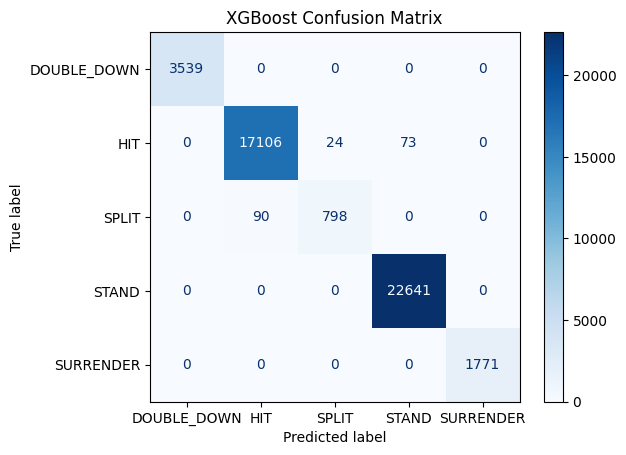

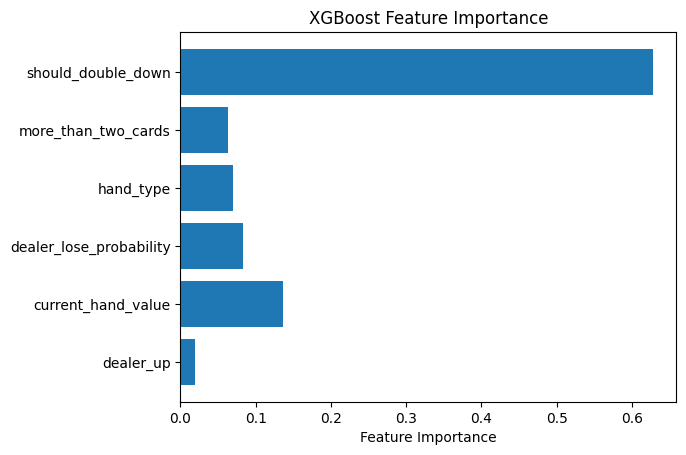

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [173]:
# === XGBoost ===
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss')
history = xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predictions
xgb_preds = xgb_clf.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

# Accuracy Score
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Define action labels (same as before)
action_labels = ['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']

# Confusion Matrix with custom labels
xgb_cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=action_labels)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

# Feature Importance Plot
xgb_importance = xgb_clf.feature_importances_
plt.barh(X.columns, xgb_importance)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

plt.figure(figsize=(12, 5))


**Confusion Matrix & Model Performance:**

The confusion matrix for the XGBoost model shows excellent performance, with very little confusion between the different action classes. The model is able to distinguish between actions with a high level of accuracy, indicating a well-trained model that effectively predicts the optimal action based on the given game state.

**Feature Importance:**

When analyzing the feature importance, it is clear that the model places significant weight on the `should_double_down` feature. The importance of this feature is far greater than others, emphasizing that the model heavily relies on whether doubling down is the right choice based on the current game scenario.

#### 5.2  Feedforward Neural Network
To train our Feedforward Neural Network model, we followed the same approach as the XGBoost model. We first separated the features and target variables. The features, `X`, consist of all the columns except for the action columns ('DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER'), which are used as our target variable `y`. For the target, we converted the action labels into numeric values by using `idxmax`, which selects the action with the highest value for each row, and then encoded it into categorical codes. **Feedforward Neural Networks also require the target to be represented as a single integer label**.

We then split the dataset into training, validation, and test sets. The training set (`X_train`, `y_train`) makes up 30% of the data, while 35% is used for validation (`X_val`, `y_val`) and the remaining 35% for testing (`X_test`, `y_test`). This split ensures that we can properly evaluate the model's performance and tune it effectively, just as we did with the XGBoost model.

Epoch 1/100


c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8828 - loss: 0.2928 - val_accuracy: 0.9541 - val_loss: 0.1129 - learning_rate: 0.0050
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9682 - loss: 0.0842 - val_accuracy: 0.9902 - val_loss: 0.0378 - learning_rate: 0.0050
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9766 - loss: 0.0713 - val_accuracy: 0.9885 - val_loss: 0.0329 - learning_rate: 0.0050
Epoch 4/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9848 - loss: 0.0446 - val_accuracy: 0.9797 - val_loss: 0.0432 - learning_rate: 0.0050
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9821 - loss: 0.0497 - val_accuracy: 0.9815 - val_loss: 0.0468 - learning_rate: 0.0050
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9868 - loss: 0.0376 - val_accuracy: 0.9863 - val_loss: 0.0461 - learning_rate: 0.0050
Epoch 7/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9859 - loss: 

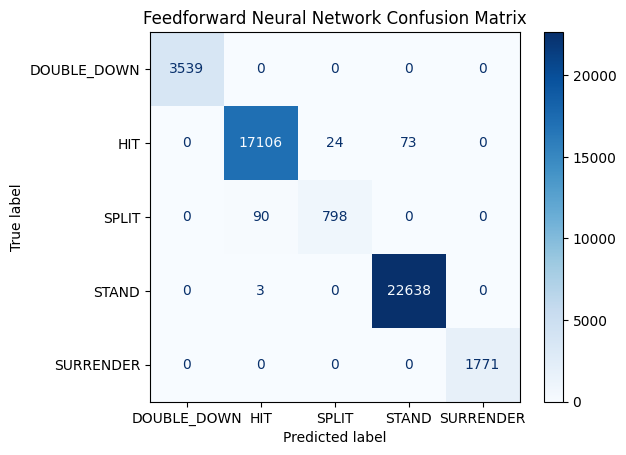

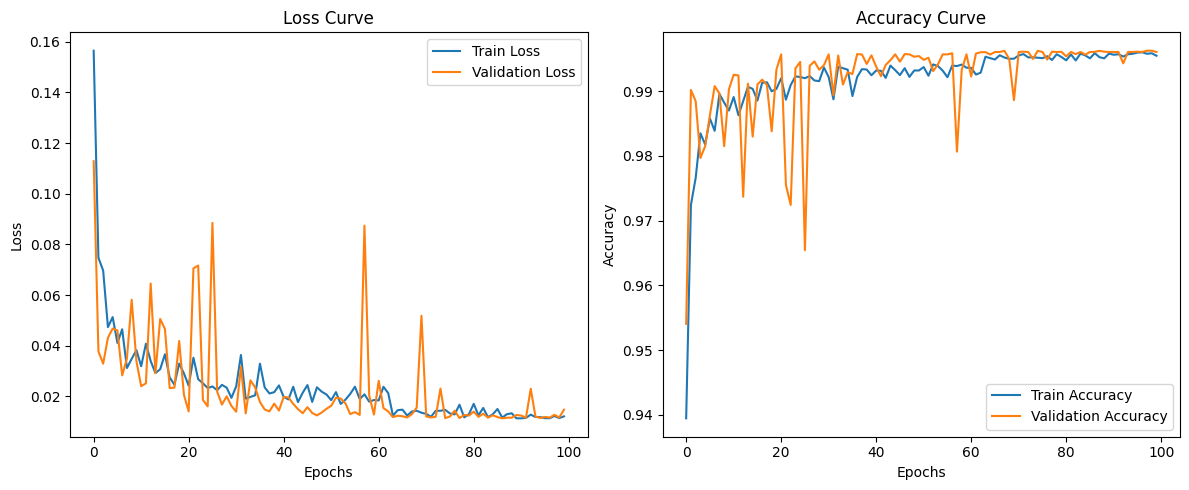

In [174]:
# === Feedforward Neural Network ===
# Convert y to categorical for neural network
y_train_nn = to_categorical(y_train, num_classes=6)
y_val_nn = to_categorical(y_val, num_classes=6)
y_test_nn = to_categorical(y_test, num_classes=6)

# Define the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=5e-3,decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)
adjust_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.5, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train_nn, 
                    epochs=100, 
                    validation_data=(X_val, y_val_nn), 
                    callbacks=[adjust_lr, es])

# Predictions
nn_preds = model.predict(X_test)
nn_preds = np.argmax(nn_preds, axis=1)

print("Feedforward Neural Network Classification Report:")
print(classification_report(y_test, nn_preds))
 

nn_accuracy = accuracy_score(y_test, nn_preds)
print(f"Feedforward Neural Network Accuracy: {nn_accuracy:.4f}")



# Define action labels 
action_labels = ['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']
# Confusion Matrix
nn_cm = confusion_matrix(y_test, nn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=action_labels)
disp.plot(cmap='Blues')
plt.title("Feedforward Neural Network Confusion Matrix")
plt.show()

# Training Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


The performance of the Feedforward Neural Network model is evaluated through various metrics, including the confusion matrix, loss curve, and accuracy curve.
</br> </br> 
The **confusion matrix** shows that the model performs well, with minimal confusion between the different action classes, indicating that the model is able to make accurate predictions for each action.

The loss curve and accuracy curve initially revealed signs of overfitting.
<p align="center">
  <img src="images/over.png" width="700"/>
</p>
To address this, we implemented early stopping and applied Learning Rate Reduction on Plateau. These strategies effectively mitigated the overfitting, as training halted when the validation performance stopped improving, and the learning rate was adjusted dynamically to ensure smoother convergence. As a result, the model achieved better generalization and improved performance on the validation set.
<p align="center">
  <img src="images/overfixed.png" width="700"/>
</p>

#### 5.3  Recurrent Neural Network
To prepare the data for training the RNN, we first split the dataset into training and testing sets. 30% of the data was allocated to the training set (`X_train`, `y_train`), while the remaining 70% was used for testing (`X_test`, `y_test`).

Next, the feature data (`X_train`, `X_test`) was reshaped to match the expected input format for the RNN. Since RNNs require the input data to have three dimensions --- `(batch_size, timesteps, feature_size)` --- we added a new axis to the data, converting the shape of the features from `(batch_size, feature_size)` to `(batch_size, 1, feature_size)`. This step ensures that the RNN can process the data correctly, where `timesteps=1` because we are working with single-step sequences.

Epoch 1/25


c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


2878/2878 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9091 - loss: 0.2445 - val_accuracy: 0.9865 - val_loss: 0.0436 - learning_rate: 0.0100
Epoch 2/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9775 - loss: 0.0653 - val_accuracy: 0.9862 - val_loss: 0.0362 - learning_rate: 0.0100
Epoch 3/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9854 - loss: 0.0437 - val_accuracy: 0.9897 - val_loss: 0.0267 - learning_rate: 0.0100
Epoch 4/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9854 - loss: 0.0458 - val_accuracy: 0.9879 - val_loss: 0.0349 - learning_rate: 0.0100
Epoch 5/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9872 - loss: 0.0386 - val_accuracy: 0.9922 - val_loss: 0.0251 - learning_rate: 0.0100
Epoch 6/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9895 - loss: 0.0312 - val_accuracy: 0.9912 - val_loss: 0.0216 - learning_rate: 0.0100
Epoch 7/25
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9887 - loss: 0.0328

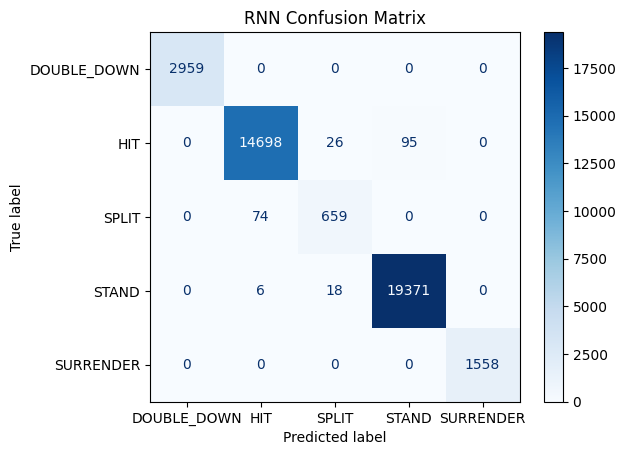

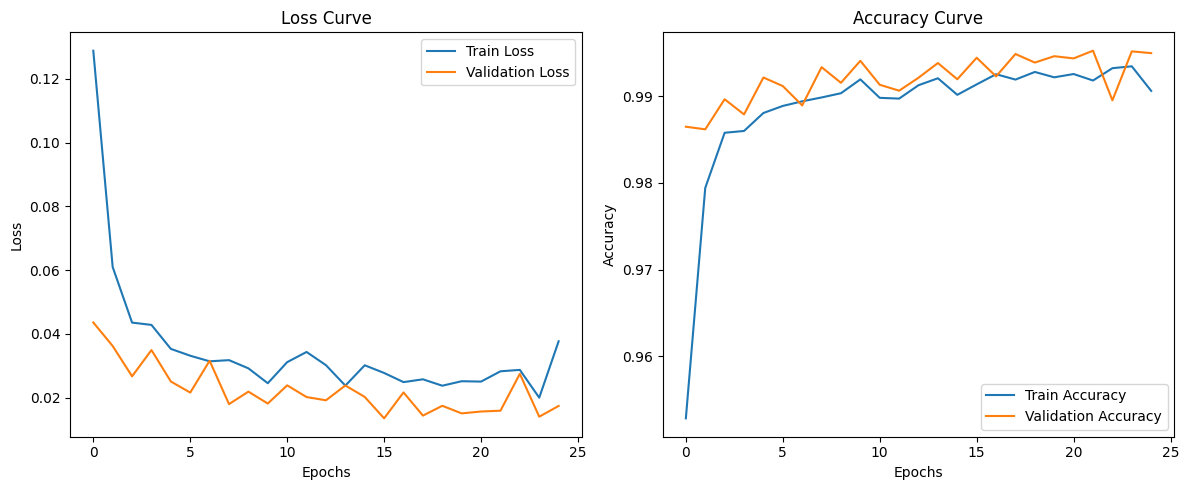

In [179]:


# Split data into training and testing sets
train_size = int(0.3 * len(X))

X_train, X_test = X[train_size:], X[:train_size]
y_train, y_test = y[train_size:], y[:train_size]

# One-hot encode the labels (y_train and y_test)
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# Reshape data for LSTM (batch_size, timesteps, feature_size)
X_train = np.expand_dims(X_train, axis=1)  # Shape becomes (batch_size, 1, feature_size)
X_test = np.expand_dims(X_test, axis=1)    # Shape becomes (batch_size, 1, feature_size)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Output layer for multi-class classification

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-2, decay=1e-5)

# Compile the model with categorical_crossentropy since labels are one-hot encoded
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)
adjust_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.5, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train_cat, epochs=25, validation_data=(X_test, y_test_cat),callbacks=[adjust_lr, es])

# Predictions
rnn_preds = model.predict(X_test)
rnn_preds = np.argmax(rnn_preds, axis=1)

# Classification Report
print("RNN Classification Report:")
print(classification_report(y_test, rnn_preds))

# Accuracy Score
rnn_accuracy = accuracy_score(y_test, rnn_preds)
print(f"RNN Accuracy: {rnn_accuracy:.4f}")

# Define action labels 
action_labels = ['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']
# Confusion Matrix
rnn_cm = confusion_matrix(y_test, rnn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=rnn_cm, display_labels=action_labels)
disp.plot(cmap='Blues')
plt.title("RNN Confusion Matrix")
plt.show()

# Training Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


The loss curve and accuracy curve initially revealed signs of overfitting similar to the Feedforward Neural Network.
<p align="center">
  <img src="images/rnnover.png" width="700"/>
</p>
To address this, we also implemented early stopping and applied Learning Rate Reduction on Plateau. 
<p align="center">
  <img src="images/rnnoverfix.png" width="700"/>
</p>

#### 5.4  Random Forest Classifier
A **Random Forest Classifier** is a machine learning model that uses multiple decision trees to make predictions. Each tree makes its own decision, and the final result is based on the majority vote from all the trees.

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3539
           1       0.99      0.99      0.99     17203
           2       0.97      0.90      0.93       888
           3       1.00      1.00      1.00     22641
           4       1.00      1.00      1.00      1771

    accuracy                           1.00     46042
   macro avg       0.99      0.98      0.99     46042
weighted avg       1.00      1.00      1.00     46042

Random Forest Accuracy: 0.9959


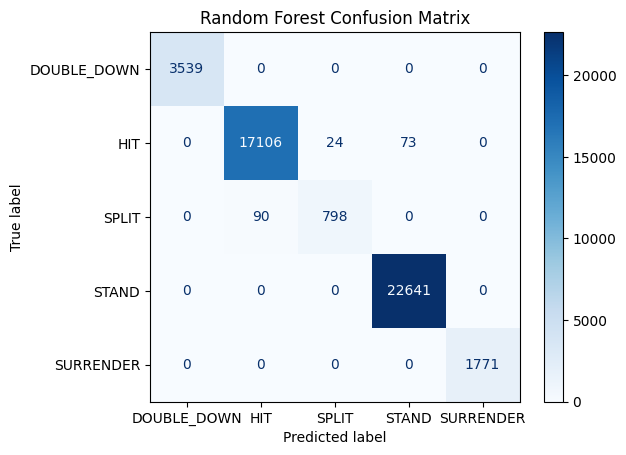

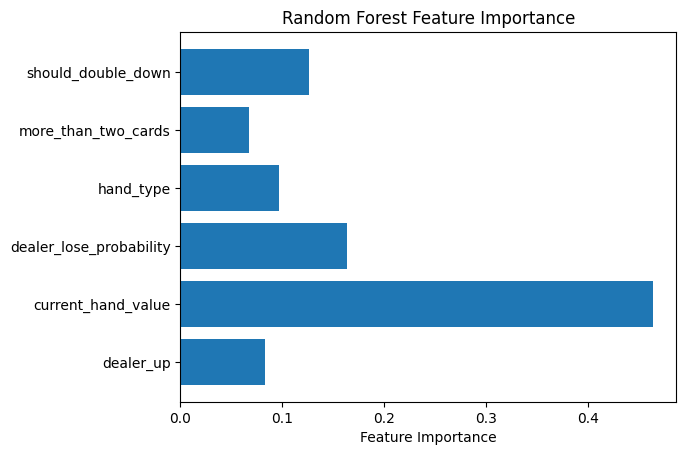

In [180]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === Random Forest ===
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
rf_preds = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

# Accuracy Score¨-
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


# Define action labels 
action_labels = ['DOUBLE_DOWN', 'HIT', 'SPLIT', 'STAND', 'SURRENDER']
# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=action_labels)
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

rf_importance = rf_clf.feature_importances_
plt.barh(X.columns, rf_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In this case, the model primarily focuses on the **current hand value** (the total of the player's cards) to make predictions, rather than strategic decisions like whether the player should **double down**, which is more emphasized by the **Gradient Boosting model (GBM)**.